In [12]:
import os
import glob
import numpy as np
import pandas as pd
import sys
from IPython.display import HTML
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, recall_score, accuracy_score, precision_score
import seaborn as sns
from scipy import stats
from sklearn.decomposition import PCA
from mpl_toolkits.mplot3d import Axes3D


In [2]:
# define the paths to results

data_path  = 'Results/*'

# get results' file paths

file_path_list  = glob.glob(data_path)

# split file names

file_names = [file_path.split('/')[1] for file_path in file_path_list]


In [3]:

# clear models with error

valid_models_path = [ data_path.split('*')[0] + file_name for file_name in file_names 
                                            if file_name.split('__')[0] != 'Error']

print('Number of models studied: {}'.format(len(file_names)))
print('Number of valid models: {}'.format(len(valid_models_path)))

# creating dictionary for model exploration

results_ditc = {}

n_elements = len(valid_models_path)

valid_columns = [
    "px1.1","py1.1","pz1.1","E1.1","eta1.1",
    "phi1.1","pt1.1","px2.1","py2.1","pz2.1",
    "E2.1","eta2.1","phi2.1","pt2.1","Delta_R.1",
    "M12.1","MET.1","S.1","C.1","HT.1","A.1"
]

for results in valid_models_path:

    #Loading results

    name_it = results.split('/')[1]

    it = name_it.split('__')[-3]

    results_ditc[it] = {}

    results_ditc[it]['data'] = []

for i,results in enumerate(valid_models_path):

    #Loading results

    name_it = results.split('/')[1]

    it = name_it.split('__')[-3]

    df = pd.read_csv(results)

    df = df[::][valid_columns]

    results_ditc[it]['data'].append(df.values)

    #Updating progress bar

    percent = (i+1)/n_elements * 100

    info = '{:.2f}% - {:d} of {:d}'.format(percent,(i+1),n_elements)

    formated_bar = '-'*int(percent) + ' '*int(100-percent)

    if i < (n_elements):
        sys.stdout.write("\r")

    sys.stdout.write('[%s] %s' % (formated_bar,info))
    sys.stdout.flush()
    


Number of models studied: 1386
Number of valid models: 693
[----------------------------------------------------------------------------------------------------] 100.00% - 693 of 693

In [4]:
right_columns = [
    "px1","py1","pz1","E1","eta1",
    "phi1","pt1","px2","py2","pz2",
    "E2","eta2","phi2","pt2","Delta_R",
    "M12","MET","S","C","HT","A"
]

y = np.zeros(30000)
y[-300:] = 1

concatenate = {}

for i,it in enumerate(results_ditc.keys()):

    for j,dcorr in enumerate(results_ditc[it]['data']):

        col = right_columns[j]

        concatenate[col] = {
            'data':0,
            'target':0,
        }

for i,it in enumerate(results_ditc.keys()):

    if i == 0:

        for j,dcorr in enumerate(results_ditc[it]['data']):

            col = right_columns[j]

            concatenate[col]['data'] = dcorr

            concatenate[col]['target'] = y


    else:

        for j,dcorr in enumerate(results_ditc[it]['data']):
           
            col = right_columns[j]

            array_tuple = (concatenate[col]['data'],dcorr)

            new_array = np.vstack(array_tuple)

            concatenate[col]['data'] = new_array

            array_tuple = (concatenate[col]['target'],y)

            new_array = np.hstack(array_tuple)

            concatenate[col]['target'] = new_array

del results_ditc

In [5]:
format_dict = {}

for dcorr in concatenate.keys():

    format_dict[dcorr]={}

    format_dict[dcorr]['erro_ks'] = {}

    format_dict[dcorr]['mse_ks'] = []

    format_dict[dcorr]['mse'] = []

    data = concatenate[dcorr]['data']

    y = concatenate[dcorr]['target']
    
    for i in range(len(data[0])):

        col = right_columns[i]

        error = data[:,i]

        signal_error = error[y==1]

        background_error = error[y==0]

        format_dict[dcorr]['erro_ks'][col] = stats.ks_2samp(signal_error, 
                                                                background_error).pvalue


    mse = np.mean(data,axis=1)

    signal_error = mse[y==1]

    background_error = mse[y==0]

    format_dict[dcorr]['mse_ks'] = stats.ks_2samp(signal_error, 
                                                        background_error).pvalue
    
    format_dict[dcorr]['mse'] = mse

/home/thiago/yes/envs/tf/lib/python3.7/site-packages/ipykernel_launcher.py:3: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  This is separate from the ipykernel package so we can avoid doing imports until


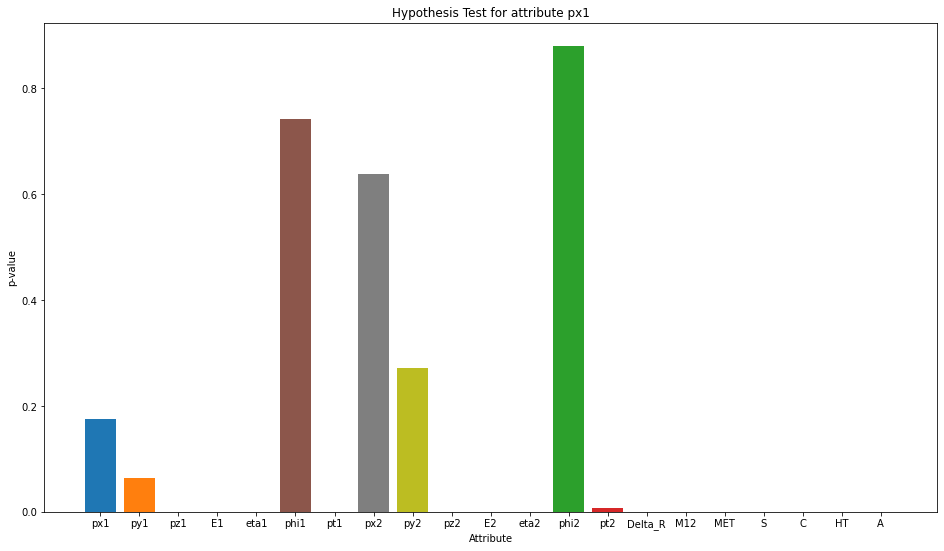

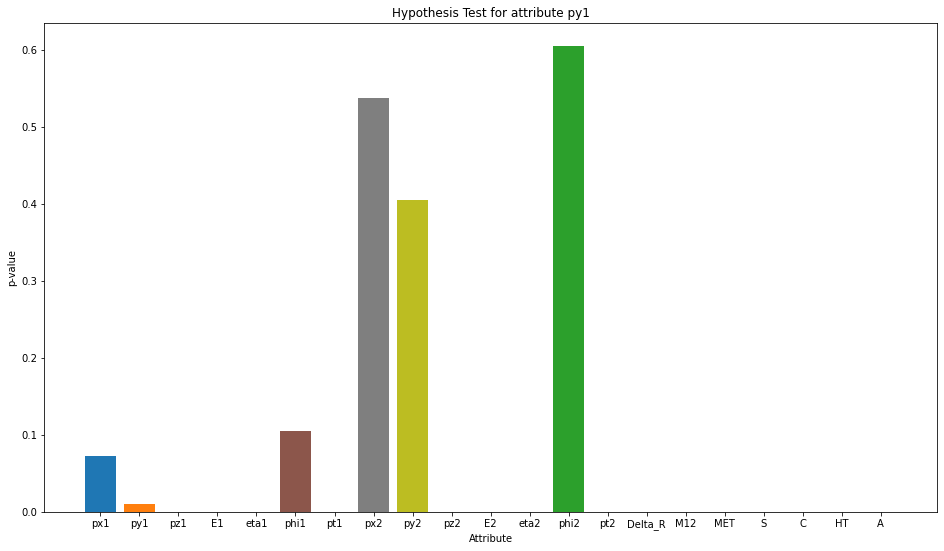

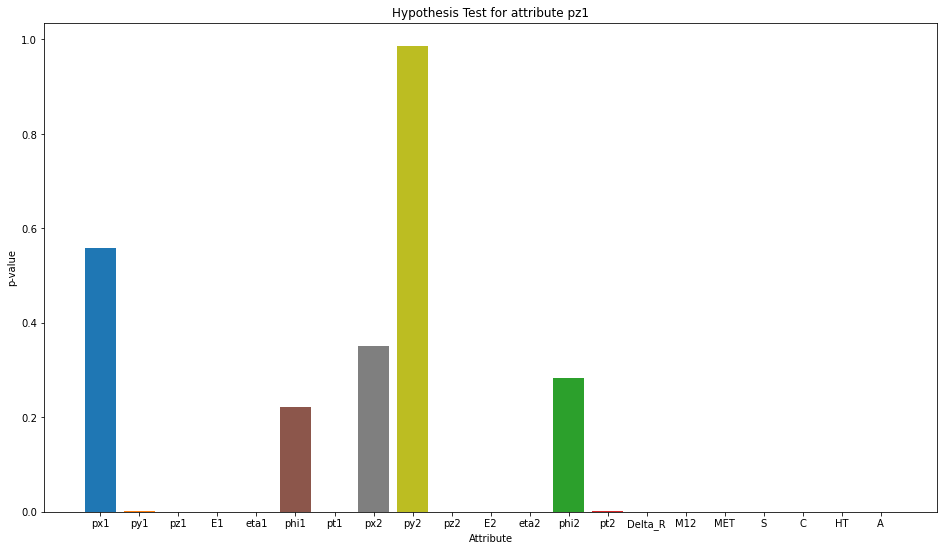

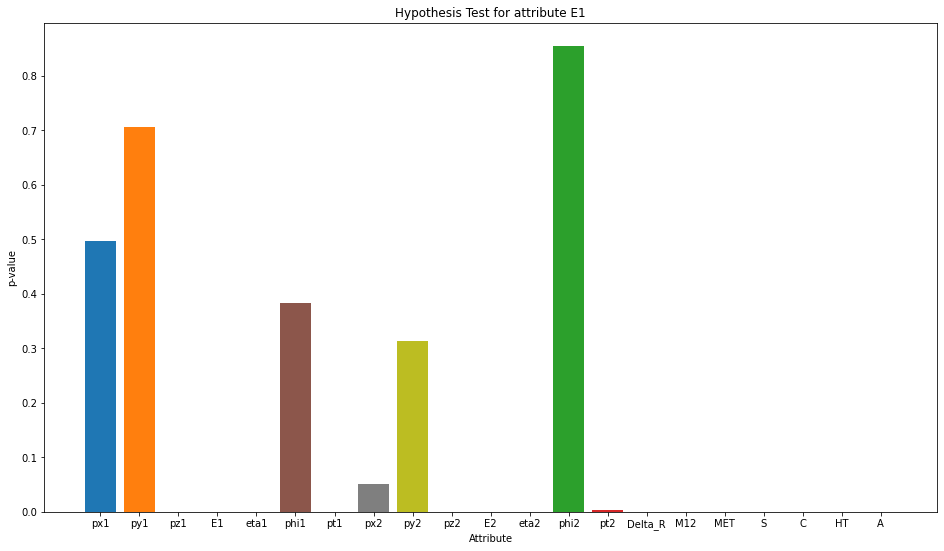

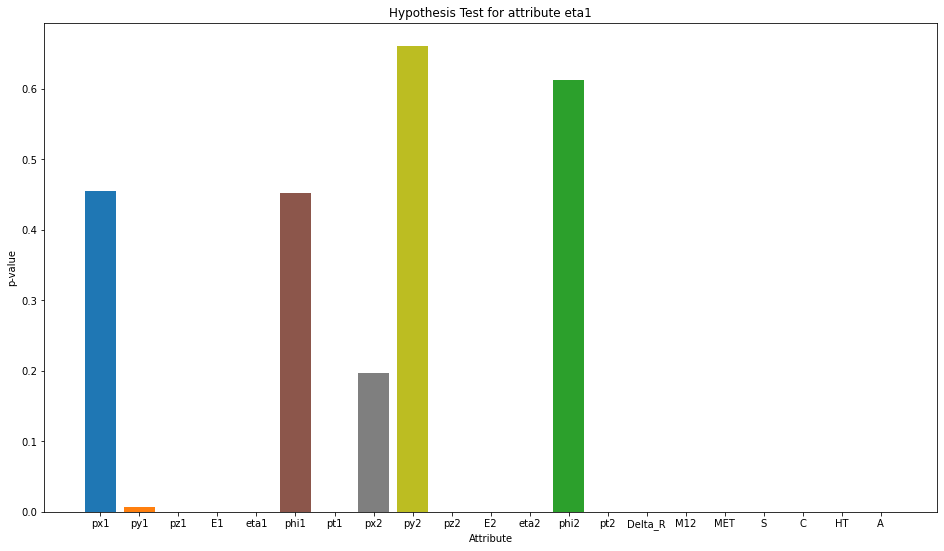

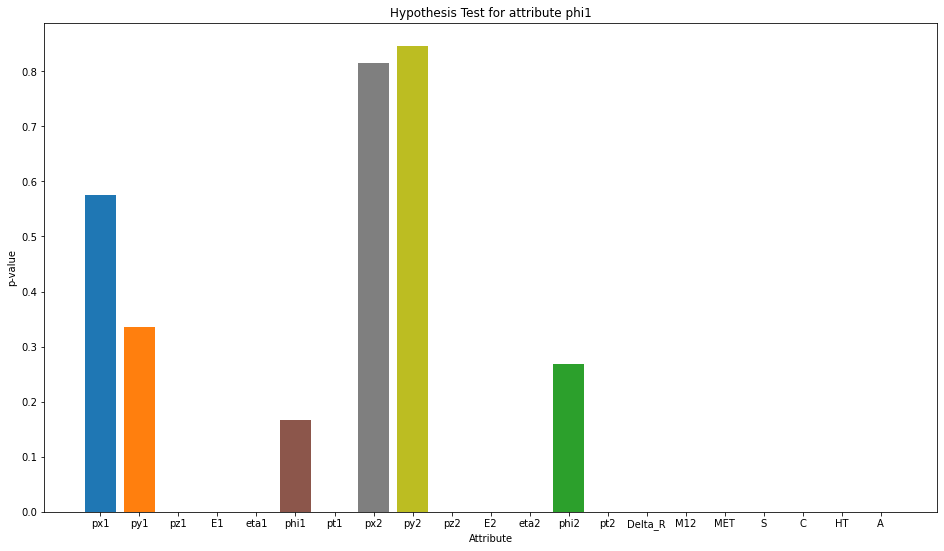

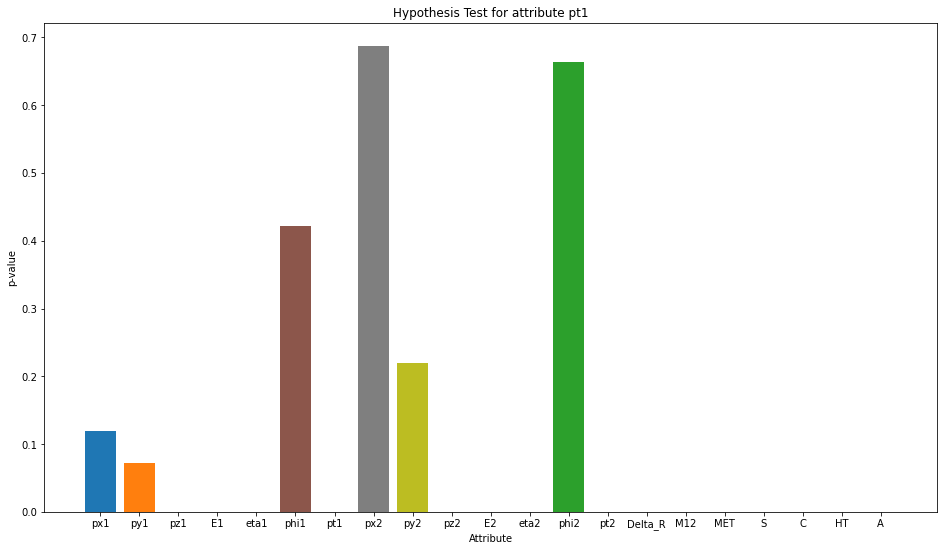

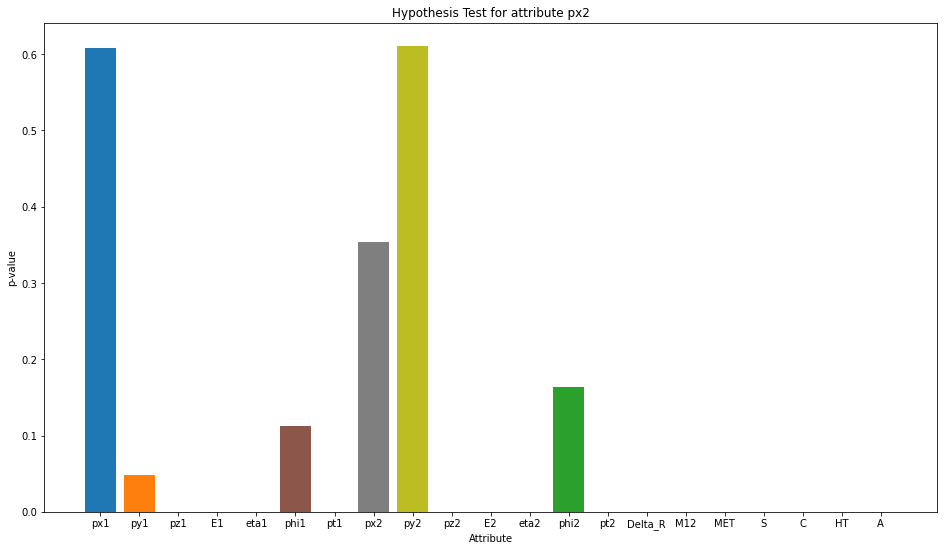

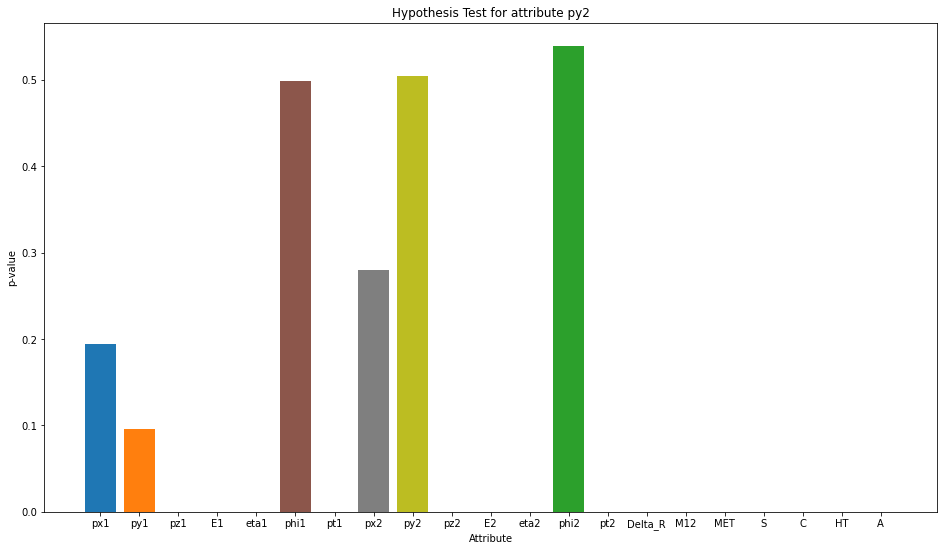

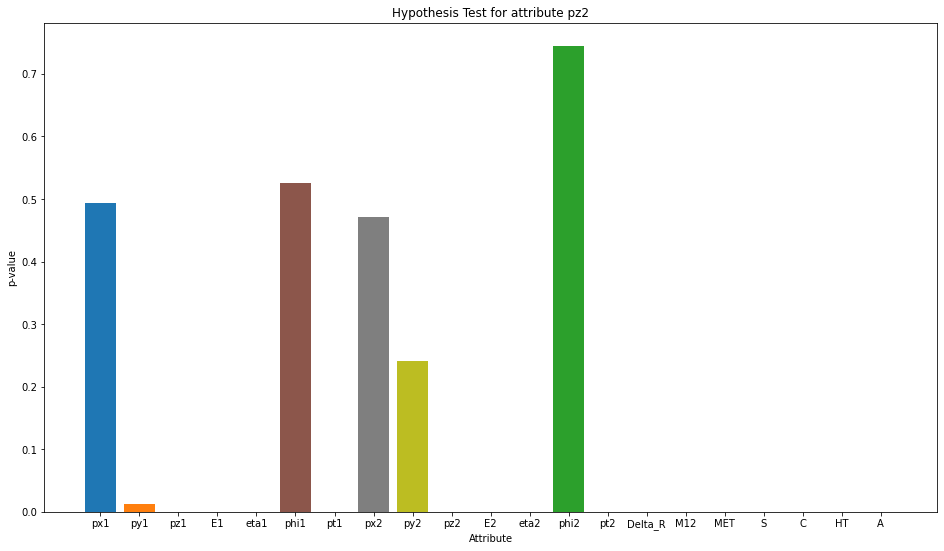

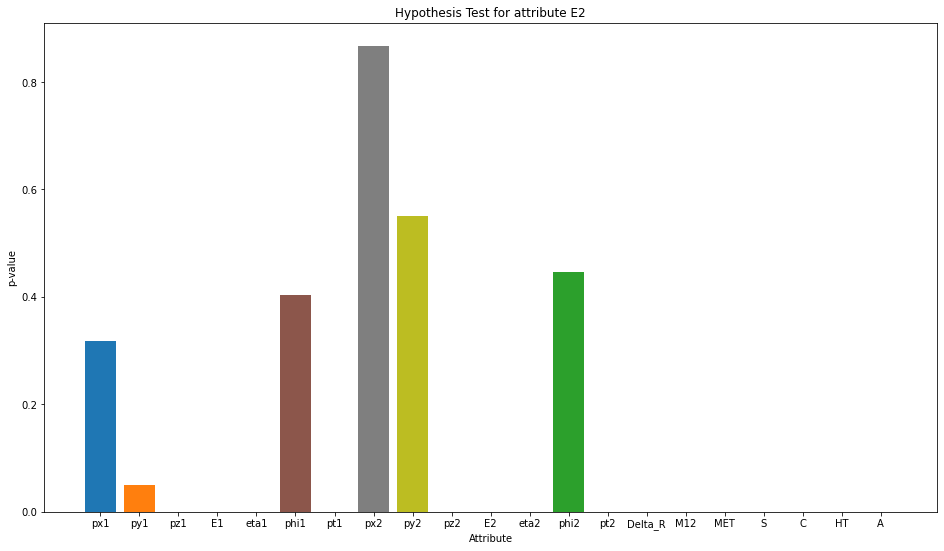

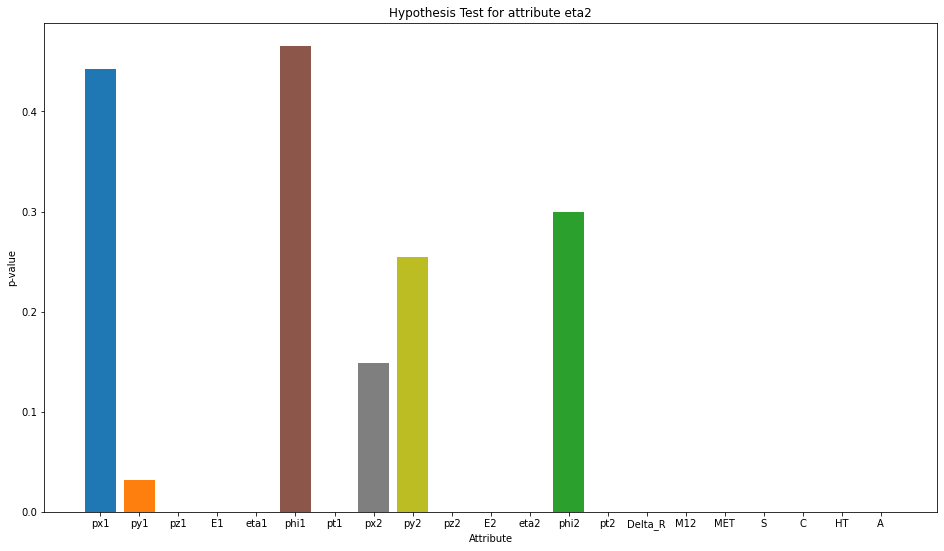

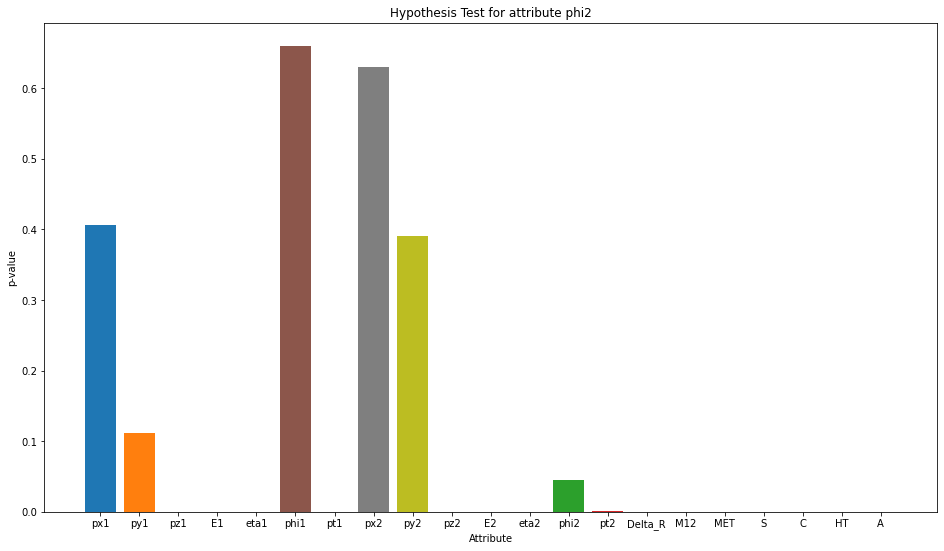

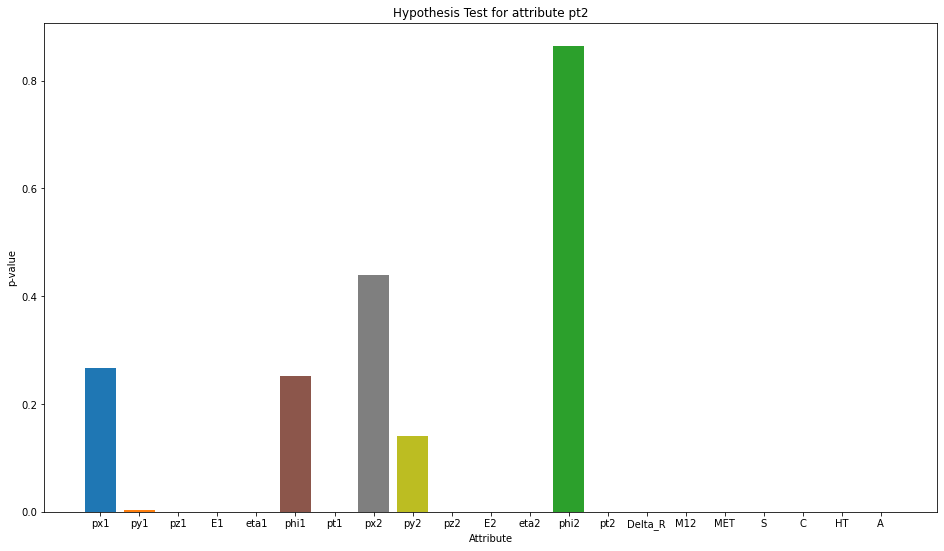

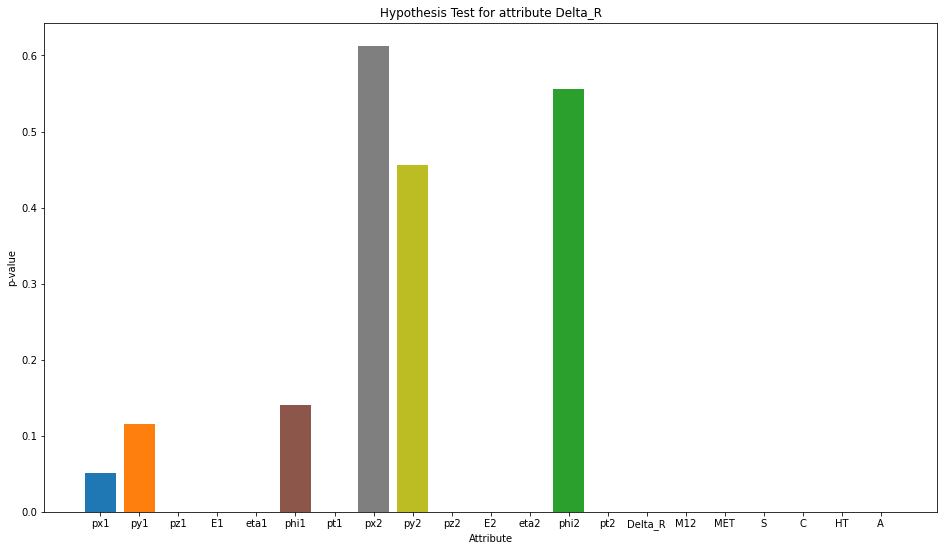

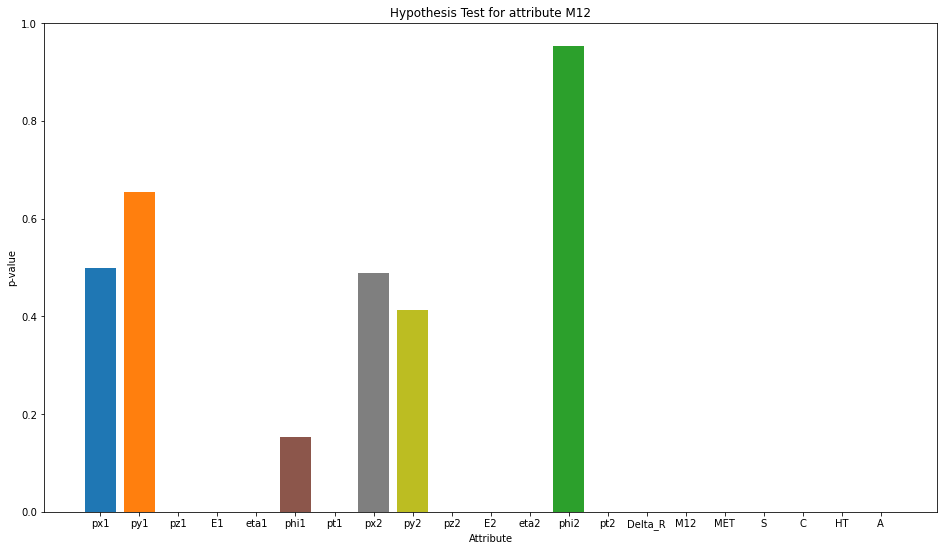

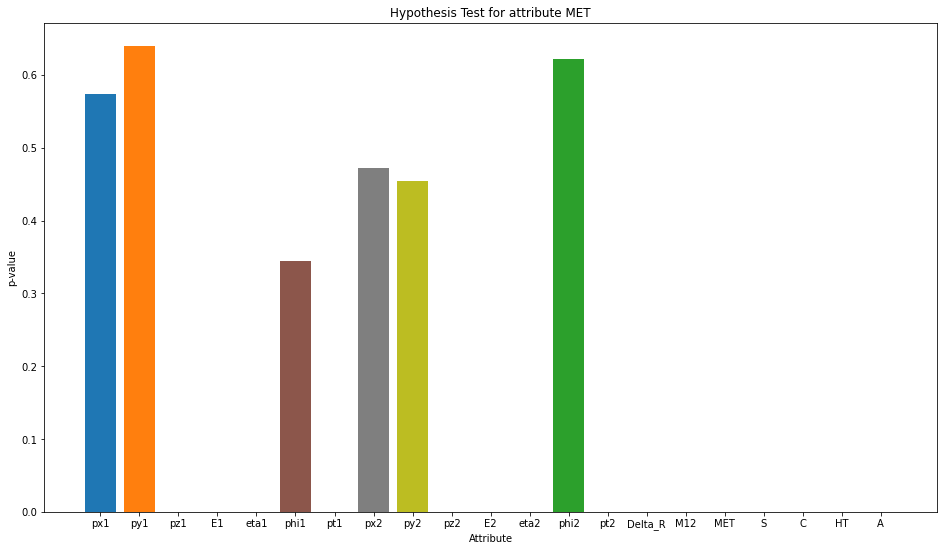

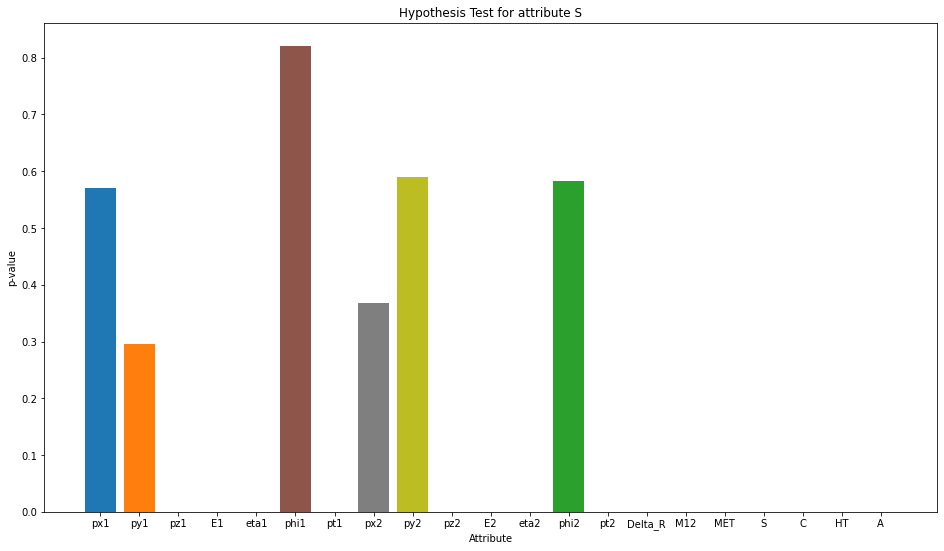

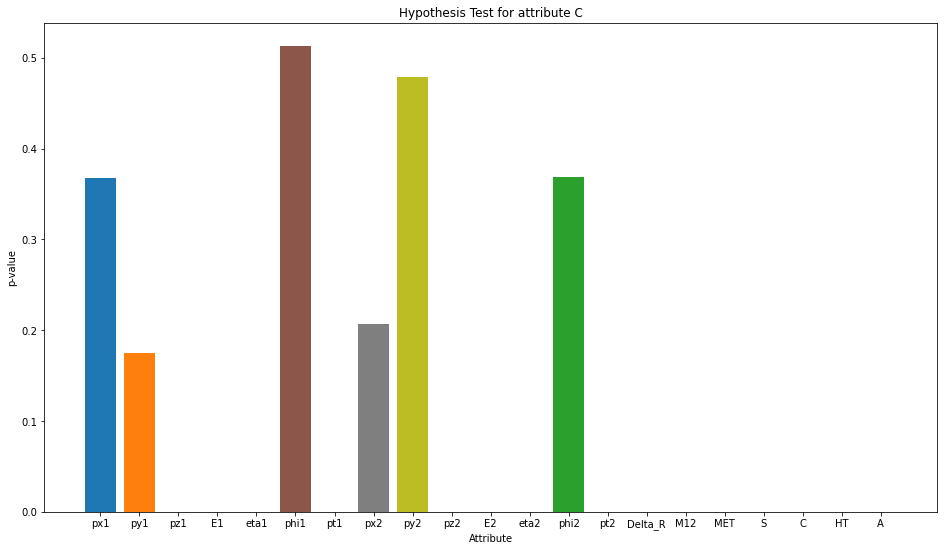

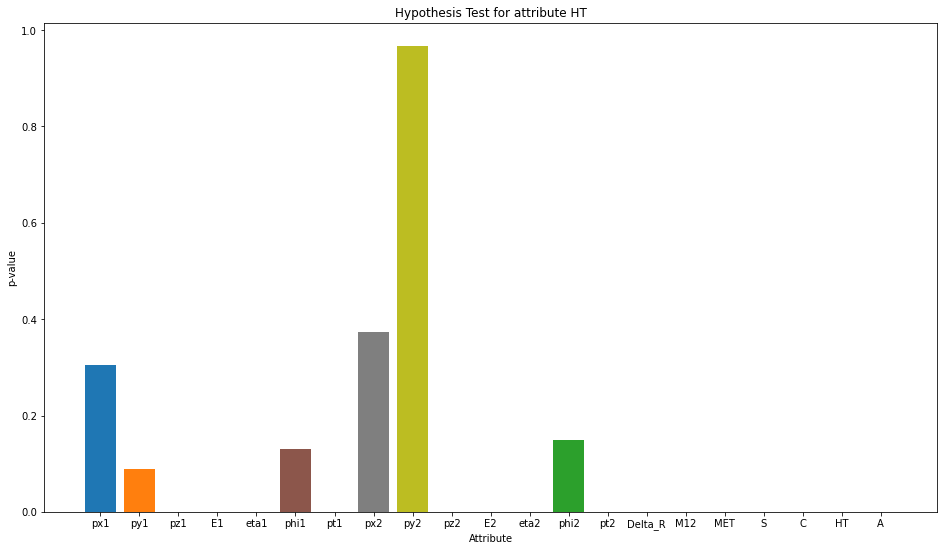

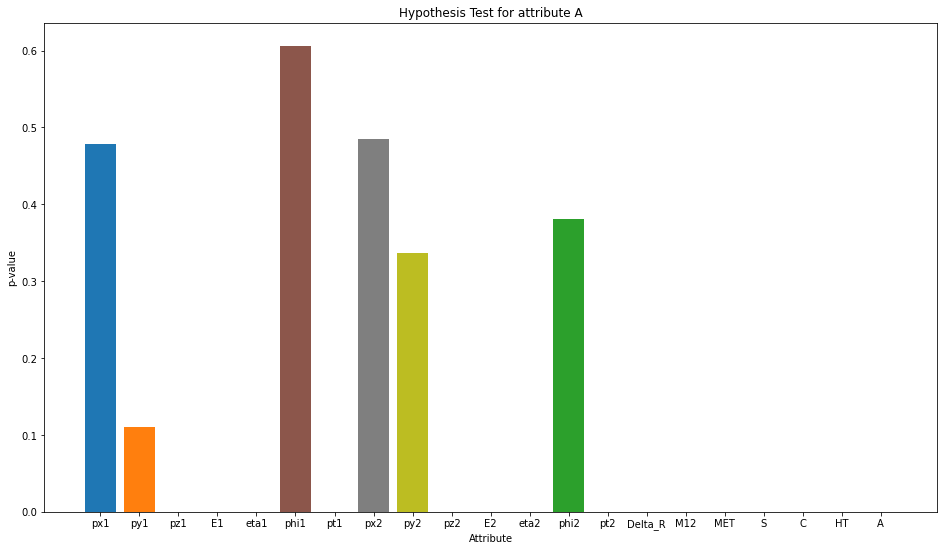

In [6]:
for dcorr in format_dict:

    fig, ax = plt.subplots()
    fig.set_size_inches(16,9)
    
    for col in format_dict[dcorr]['erro_ks'].keys():

        p_value = format_dict[dcorr]['erro_ks'][col] 

        ax.bar(col , p_value)

    plt.title("Hypothesis Test for attribute {}".format(dcorr))
    plt.ylabel("p-value")
    plt.xlabel("Attribute")

    fig.savefig('Figures/reconstruction-error__' + dcorr + '.png', 
                bbox_inches='tight'
            )

In [7]:
mse_ks_list = [format_dict[dcorr]['mse_ks'] for dcorr in format_dict.keys()]

sorted_index = np.argsort(mse_ks_list)

sort_error_difference = [mse_ks_list[i] for i in sorted_index]

model_names = [name for name in format_dict.keys()]

sort_model_names = [model_names[i] for i in sorted_index]

small_model_names = sort_model_names[:10]

error_df = pd.DataFrame(np.transpose(sort_error_difference[:10]),index=small_model_names)

display(error_df)


,0
py1,4.763557e-30
A,4.576100e-28
E1,4.911404e-28
py2,6.355756e-26
eta2,6.761354e-24
C,7.143612e-23
phi2,8.699452e-22
E2,1.046022e-21
phi1,2.124411e-19
M12,2.401862e-19


In [8]:
best_model_dict = concatenate[sort_model_names[0]]

best_model_stats = format_dict[sort_model_names[0]]

del format_dict

del concatenate

error_class = pd.DataFrame({'Reconstruction_error': best_model_stats['mse'],
                        'True_class': best_model_dict['target']})

error_class                  

,Reconstruction_error,True_class
0,0.399345,0.0
1,0.314425,0.0
2,0.298500,0.0
3,0.333348,0.0
4,0.316716,0.0
...,...,...
989995,0.335661,1.0
989996,0.279268,1.0
989997,0.288725,1.0
989998,0.297028,1.0


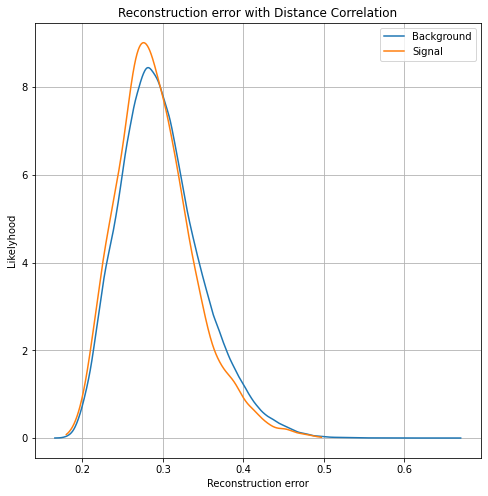

In [9]:
threshold_fixed = 0.12
groups = error_class.groupby('True_class')

fig, ax = plt.subplots(1,1)
fig.set_size_inches(8,8)

for name, group in groups:

    min_error = np.min(group.Reconstruction_error)

    max_error = np.max(group.Reconstruction_error)

    kernel = stats.gaussian_kde(group.Reconstruction_error)

    error_eval = np.linspace(min_error,max_error,num=1000)

    if name == 0:
        labels = "Background"
    
    else:
        labels = "Signal"


    ax.plot(error_eval, kernel(error_eval), 
            ms=3.5, linestyle='-',
            label= labels)

ax.legend()
ax.set_title("Reconstruction error with Distance Correlation")
ax.set_xlabel("Reconstruction error")
ax.set_ylabel("Likelyhood")
ax.grid()

plt.show()


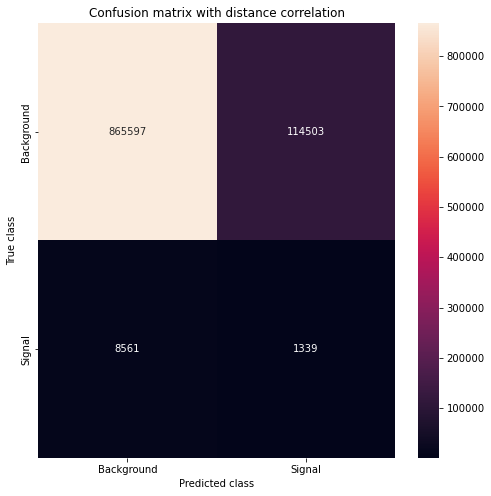

 Accuracy:  0.8756929292929293
 Recall:  0.13525252525252526
 Precision:  0.011558847395590545


In [10]:
LABELS = ['Background','Signal']

fig, ax = plt.subplots(1,1)
fig.set_size_inches(8,8)

# with DisCo

threshold_fixed = 0.24

pred_y = [1 if e < threshold_fixed else 0 for e in error_class.Reconstruction_error.values]
error_class['pred'] = pred_y
conf_matrix = confusion_matrix(error_class.True_class, pred_y)

sns.heatmap(conf_matrix, xticklabels=LABELS, yticklabels=LABELS, annot=True, fmt="d")
ax.set_title("Confusion matrix with distance correlation")
ax.set_ylabel('True class')
ax.set_xlabel('Predicted class')

plt.show()

# print Accuracy, precision and recall
print(" Accuracy: ",accuracy_score(error_class['True_class'], error_class['pred']))
print(" Recall: ",recall_score(error_class['True_class'], error_class['pred']))
print(" Precision: ",precision_score(error_class['True_class'], error_class['pred']))


# Análise de PCA

0.5421814515475927


/home/thiago/yes/envs/tf/lib/python3.7/site-packages/ipykernel_launcher.py:28: MatplotlibDeprecationWarning: Axes3D(fig) adding itself to the figure is deprecated since 3.4. Pass the keyword argument auto_add_to_figure=False and use fig.add_axes(ax) to suppress this warning. The default value of auto_add_to_figure will change to False in mpl3.5 and True values will no longer work in 3.6.  This is consistent with other Axes classes.


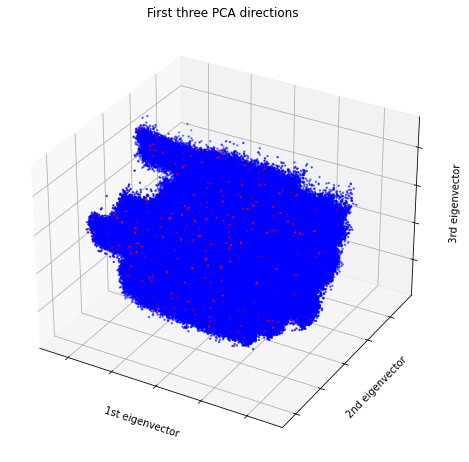

In [27]:
%matplotlib inline

data = best_model_dict['data']

y = best_model_dict['target']

pca = PCA(n_components=3).fit(data)

print(np.sum(pca.explained_variance_))

reduced = pca.transform(data)

colors = []

for target in y:

    if target == 0:
        colors.append('b')
    
    else:
        colors.append('r')

# To getter a better understanding of interaction of the dimensions
# plot the first three PCA dimensions

fig = plt.figure(1, figsize=(8, 6))

ax = Axes3D(fig)

ax.scatter(reduced[:, 0], reduced[:, 1], reduced[:, 2], c=colors,
           cmap=plt.cm.Set1, s=2)

ax.set_title("First three PCA directions")
ax.set_xlabel("1st eigenvector")
ax.w_xaxis.set_ticklabels([])
ax.set_ylabel("2nd eigenvector")
ax.w_yaxis.set_ticklabels([])
ax.set_zlabel("3rd eigenvector")
ax.w_zaxis.set_ticklabels([])

plt.show()